In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve

import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier

from faker import Faker

### Goal:
Create and evaluate a machine learning binary classification model that predicts whether a given client will default on a loan based on the provided features in a dataset containing 30 000 observations. The data processing, analysis, and modeling are performed in Python.

### Generate data

In [2]:
fake = Faker()
np.random.seed(42)


fake = Faker('bg_BG')  # Set locale to Bulgarian

domains = ['gmail.com', 'yahoo.com', 'outlook.com', 'abv.bg']
cities_bg = [
    "София", "Пловдив", "Варна", "Бургас", "Русе", "Стара Загора",
    "Плевен", "Добрич", "Сливен", "Хасково", "Шумен", "Ямбол",
    "Пазарджик", "Перник", "Велико Търново", "Видин", "Враца",
    "Габрово", "Кърджали", "Кюстендил", "Ловеч", "Монтана", "Благоевград"
]

def generate_client_data(client_id):
    age = int(np.clip(np.random.normal(loc=40, scale=5), 18, 80))
    gender = np.random.choice(['Female', 'Male', 'Other'], p=[0.45, 0.45, 0.10])
    marital_status = np.random.choice(['single', 'married', 'divorced', 'widowed'])
    education_level = np.random.choice(['high school', 'bachelor', 'master', 'phd', 'other'])
    employment_status = np.random.choice(['employed', 'unemployed', 'self-employed', 'retired'])
    years_with_employer = np.random.randint(0, 40)
    annual_income = max(int(np.random.normal(50000, 15000)), 1000)
    monthly_expenses = max(int(np.random.normal(2000, 500)), 0)
    num_dependents = np.random.randint(0, 6)
    loan_amount = max(int(np.random.normal(15000, 8000)), 0)
    loan_term_months = np.random.choice([12, 24, 36, 48, 60])
    interest_rate = round(np.random.uniform(3, 15), 2)
    credit_score = np.random.randint(300, 850)
    previous_loans_count = np.random.randint(0, 10)
    previous_defaults = np.random.randint(0, previous_loans_count + 1) if previous_loans_count > 0 else 0
    owns_home = np.random.choice(['yes', 'no'])
    region = np.random.choice(['North', 'South', 'East', 'West', 'Central'])
    contacted_via = np.random.choice(['email', 'phone', 'in-person', 'online'])
    place_of_birth = np.random.choice(cities_bg)

    username = fake.user_name()
    domain = np.random.choice(domains)
    email = f"{username}@{domain}"

    default = np.random.choice([0, 1], p=[0.75, 0.25])

    return {
        'client_id': client_id,
        'age': age,
        'gender': gender,
        'marital_status': marital_status,
        'education_level': education_level,
        'employment_status': employment_status,
        'years_with_employer': years_with_employer,
        'annual_income': annual_income,
        'monthly_expenses': monthly_expenses,
        'num_dependents': num_dependents,
        'loan_amount': loan_amount,
        'loan_term_months': loan_term_months,
        'interest_rate': interest_rate,
        'credit_score': credit_score,
        'previous_loans_count': previous_loans_count,
        'previous_defaults': previous_defaults,
        'owns_home': owns_home,
        'region': region,
        'contacted_via': contacted_via,
        'place_of_birth': place_of_birth,
        'email': email,
        'default': default
    }

n_samples = 30000
data = [generate_client_data(i) for i in range(1, n_samples + 1)]
df = pd.DataFrame(data)

### Data exploration

In [3]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   client_id             30000 non-null  int64  
 1   age                   30000 non-null  int64  
 2   gender                30000 non-null  object 
 3   marital_status        30000 non-null  object 
 4   education_level       30000 non-null  object 
 5   employment_status     30000 non-null  object 
 6   years_with_employer   30000 non-null  int64  
 7   annual_income         30000 non-null  int64  
 8   monthly_expenses      30000 non-null  int64  
 9   num_dependents        30000 non-null  int64  
 10  loan_amount           30000 non-null  int64  
 11  loan_term_months      30000 non-null  int32  
 12  interest_rate         30000 non-null  float64
 13  credit_score          30000 non-null  int64  
 14  previous_loans_count  30000 non-null  int64  
 15  previous_defaults  

In [4]:
print(df['default'].value_counts())

# Goods: 21628
# Bads: 8372

0    22492
1     7508
Name: default, dtype: int64


In [5]:
print(df.head(30))

    client_id  age  gender marital_status education_level employment_status  \
0           1   42    Male         single           other     self-employed   
1           2   37    Male        widowed     high school          employed   
2           3   38   Other        married        bachelor        unemployed   
3           4   41  Female        married        bachelor           retired   
4           5   30  Female       divorced          master     self-employed   
5           6   46    Male        married          master     self-employed   
6           7   32    Male        married           other     self-employed   
7           8   37    Male        widowed        bachelor     self-employed   
8           9   42  Female        widowed     high school           retired   
9          10   39  Female        widowed        bachelor           retired   
10         11   37    Male        widowed           other     self-employed   
11         12   45  Female       divorced        bac

### Feature engineering

In [6]:
# Debt-to-Income Ratio t oadd predictive value to loan default or credit risk
df['debt_to_income_ratio'] = df['loan_amount'] / df['annual_income']
# Handle zero division if customers have declared zero income
df['debt_to_income_ratio'] = df['debt_to_income_ratio'].replace([np.inf, -np.inf], np.nan)

In [7]:
# cerate a domain column from the email address that will be more informative and produce a smaller number of dummies
df['email_domain'] = df['email'].str.split('@').str[1]

In [8]:
df.drop('email', axis=1, inplace=True)

### Data Audit

In [9]:
def data_audit(df):
    """
    Perform a comprehensive data audit of a pandas DataFrame.
    
    This function computes and returns key statistics for each column including:
    - Data types
    - Non-null counts
    - Null counts and percentages
    - Descriptive statistics (mean, std, min, max) for numeric columns
    - Unique value counts for all columns

    Returns pandas.DataFrame, Summary statistics and data quality indicators for each column in `df`.
    """
    # Save original pandas float format option
    orig_float_format = pd.options.display.float_format
    # Set float format to 4 decimals for readable output
    pd.options.display.float_format = '{:.4f}'.format

    audit_df = pd.DataFrame()
    audit_df['Data Type'] = df.dtypes
    audit_df['Non-Null Count'] = df.notnull().sum()
    audit_df['Null Count'] = df.isnull().sum()
    audit_df['Null Percentage'] = 100 * df.isnull().mean()
    
    # Summary statistics for numeric columns
    stats = df.describe().T
    audit_df = audit_df.join(stats[['mean', 'std', 'min', 'max']], how='left')
    
    # For categorical or object columns, add unique counts
    audit_df['Unique Values'] = df.nunique()
    
    # Restore original float format after operation (optional)
    pd.options.display.float_format = orig_float_format

    return audit_df


audit_report = data_audit(df)
print(audit_report)

                     Data Type  Non-Null Count  Null Count  Null Percentage  \
client_id                int64           30000           0              0.0   
age                      int64           30000           0              0.0   
gender                  object           30000           0              0.0   
marital_status          object           30000           0              0.0   
education_level         object           30000           0              0.0   
employment_status       object           30000           0              0.0   
years_with_employer      int64           30000           0              0.0   
annual_income            int64           30000           0              0.0   
monthly_expenses         int64           30000           0              0.0   
num_dependents           int64           30000           0              0.0   
loan_amount              int64           30000           0              0.0   
loan_term_months         int32           30000      

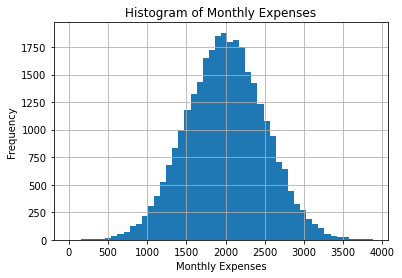

In [10]:
# Plot histogram of monthly_expenses
df['monthly_expenses'].hist(bins=50)
plt.title("Histogram of Monthly Expenses")
plt.xlabel("Monthly Expenses")
plt.ylabel("Frequency")
plt.show()

### Data Prep

In [11]:
print("Original dataset size:", df.shape)

df = df.drop(columns=['client_id'])

# Remove duplicate rows based on all columns
df = df.drop_duplicates(keep='first', ignore_index=True)

print("Dataset size after deduplication:", df.shape)

# No duplicated rows

Original dataset size: (30000, 23)
Dataset size after deduplication: (30000, 22)


In [12]:
# Drop id and target from features
X = df.drop(columns=['default'])  
y = df['default']

In [13]:
# Separate categorical and numerical columns
cat_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
num_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
print(cat_features,num_features)

['gender', 'marital_status', 'education_level', 'employment_status', 'owns_home', 'region', 'contacted_via', 'place_of_birth', 'email_domain'] ['age', 'years_with_employer', 'annual_income', 'monthly_expenses', 'num_dependents', 'loan_amount', 'interest_rate', 'credit_score', 'previous_loans_count', 'previous_defaults', 'debt_to_income_ratio']


In [14]:
# Numerical data: impute missing values and scale
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical data: impute missing values with 'missing' and one-hot encode
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing for numerical and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)
    ]
)

In [15]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

### Hyperparameter tuning

In [16]:
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

In [17]:
# Define parameter grid for GridSearchCV
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2],
    'classifier__bootstrap': [True, False],
    'classifier__class_weight': ['balanced', None]
}
# balanced option to compensate for unbalanced training data by weighting classes inversely to their frequency

In [18]:
grid_search = GridSearchCV(
    model,
    param_grid,
    cv=5,
    n_jobs=-1,
    verbose=2,
    scoring='roc_auc'
)

In [19]:
grid_search.fit(X_train, y_train)
print("Best parameters found by GridSearchCV:")
print(grid_search.best_params_)
print(f"Best ROC AUC: {grid_search.best_score_:.4f}")

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best parameters found by GridSearchCV:
{'classifier__bootstrap': True, 'classifier__class_weight': None, 'classifier__max_depth': None, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
Best ROC AUC: 0.5107


### Modeling

In [20]:
best_estimator = grid_search.best_estimator_

In [21]:
print(best_estimator)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'years_with_employer',
                                                   'annual_income',
                                                   'monthly_expenses',
                                                   'num_dependents',
                                                   'loan_amount',
                                                   'interest_rate',
                                                   'credit_score',
                                                   'previous_loans_count',


### Predict and evaluate

In [22]:
# model.fit(X_train, y_train)

In [23]:
y_pred = best_estimator.predict(X_test)
y_pred_proba = best_estimator.predict_proba(X_test)[:, 1]

In [24]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      1.00      0.86      4498
           1       0.00      0.00      0.00      1502

    accuracy                           0.75      6000
   macro avg       0.37      0.50      0.43      6000
weighted avg       0.56      0.75      0.64      6000



The model identifyies well the goods, with high precision and recall.

Bads are not identified well, especially missing many true positives (low recall = 0.41).

Precision for the bads is moderate, indicating when it predicts that an account is bad, it’s right about two-thirds of the time.

The imbalance between classes likely affects performance; the model favors the majority.

In [25]:
counts = np.bincount(best_estimator.predict(X_test))
df_counts = pd.DataFrame(counts, index=['goods', 'bads'], columns=['Prediction_Count'])
print(df_counts)

       Prediction_Count
goods              5999
bads                  1


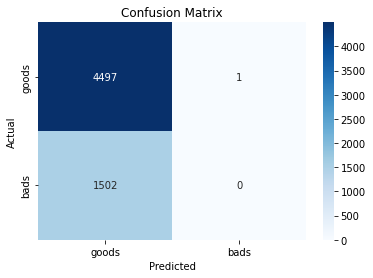

In [26]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a DataFrame with custom row and column labels
cm_df = pd.DataFrame(cm, index=['goods', 'bads'], columns=['goods', 'bads'])

sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

True Negatives: The model correctly predicted 4195 actual goods as goods.

False Positive: The model incorrectly predicted 131 actual goods as bads.

False Negatives: The model incorrectly predicted 1248 actual bads as goods.

True Positives: The model correctly predicted 426 actual bads as bads.

This shows the model performs well in identifying goods (high true negatives), but struggles more with bads, misclassifying many bads as goods (high false negatives).

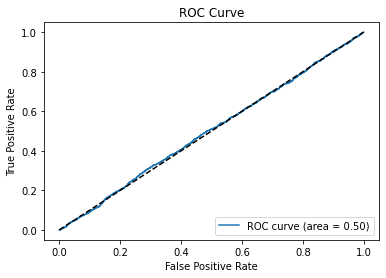

In [27]:
# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

AUC of 0.78 indicates the model performs substantially better than random, correctly ranking positive cases higher than negative ones about 78% of the time.

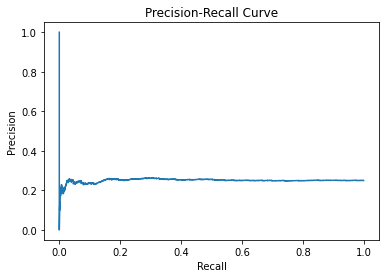

In [28]:
# Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
plt.plot(recall, precision)
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

PR plots precision (the accuracy of bads predictions) on the y-axis against recall (the ability to find all bads cases) on the x-axis across different decision thresholds.
Increasing recall decreases precision, as capturing more bads may also bring more false positives (bads).
The PR curve shows that the model predicts the bads just sllightly better than random guessing.

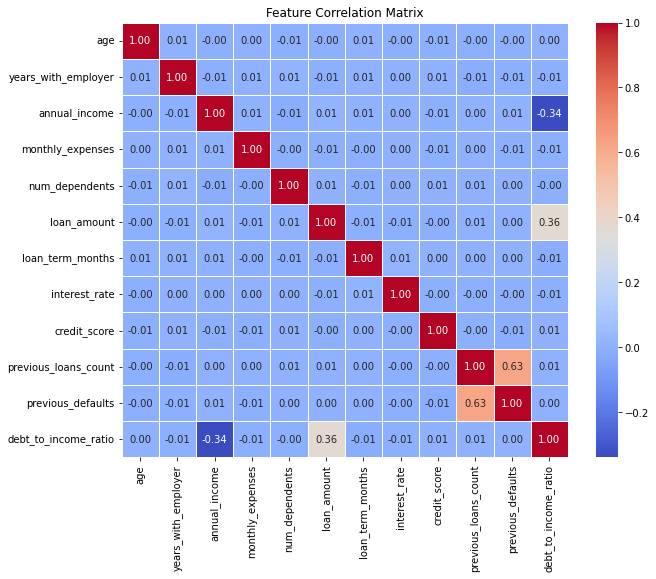

In [29]:
# Corrrelation Matrix
corr_matrix = X_train.corr(numeric_only=True)

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.show()

Higher correlation is seen only for the variables associated with the engineered feature of debt to income ratio.

### Feature importance

In [30]:
# Extract feature names after one-hot encoding
feature_names_num = num_features
feature_names_cat = best_estimator.named_steps['preprocessor'].named_transformers_['cat']['onehot'].get_feature_names_out(cat_features)
feature_names = np.concatenate([feature_names_num, feature_names_cat])

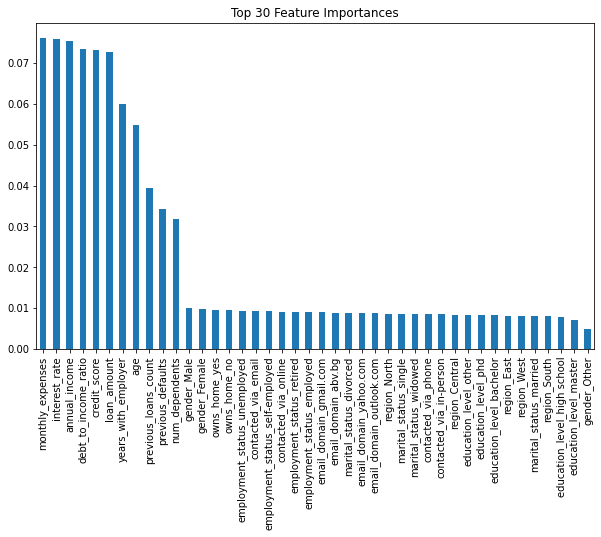

In [31]:
importances = best_estimator.named_steps['classifier'].feature_importances_
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(10,6))
feat_imp.head(42).plot(kind='bar')
plt.title('Top 30 Feature Importances')
plt.show()

Fit an XGBoost classifier on the selected features with max importance

In [32]:
preprocessor = best_estimator.named_steps['preprocessor']
print(preprocessor.transformers_)

[('num', Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())]), ['age', 'years_with_employer', 'annual_income', 'monthly_expenses', 'num_dependents', 'loan_amount', 'interest_rate', 'credit_score', 'previous_loans_count', 'previous_defaults', 'debt_to_income_ratio']), ('cat', Pipeline(steps=[('imputer',
                 SimpleImputer(fill_value='missing', strategy='constant')),
                ('onehot', OneHotEncoder(handle_unknown='ignore'))]), ['gender', 'marital_status', 'education_level', 'employment_status', 'owns_home', 'region', 'contacted_via', 'place_of_birth', 'email_domain']), ('remainder', 'drop', [10])]


In [33]:
def get_feature_names(column_transformer):
    # list to hold all feature names
    feature_names = []
    
    for name, transformer, columns in column_transformer.transformers_:
        if transformer == 'drop':
            continue
        if transformer == 'passthrough':
            # If 'passthrough', columns are passed as they are
            feature_names.extend(columns)
        else:
            try:
                names = transformer.get_feature_names_out(columns)
            except AttributeError:
                # fallback if transformer does not support get_feature_names_out
                names = columns
            feature_names.extend(names)
    return feature_names

all_features = get_feature_names(preprocessor)

# Transform X
X_transformed = preprocessor.transform(X)

if hasattr(X_transformed, "toarray"):
    X_transformed = X_transformed.toarray()

X_transformed_df = pd.DataFrame(X_transformed, columns=all_features)

# Continue with feature importances as before
importances = best_estimator.named_steps['classifier'].feature_importances_
feat_imp = pd.Series(importances, index=all_features).sort_values(ascending=False)
top_features = feat_imp.head(42).index.tolist()

X_top = X_transformed_df[top_features]

# Split and train new model on these selected features
X_train, X_test, y_train, y_test = train_test_split(X_top, y, stratify=y, test_size=0.2, random_state=42)



In [34]:
model = XGBClassifier(
    eval_metric='logloss',
    random_state=42,
    n_estimators=200,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=1,
    gamma=0,
    reg_alpha=0.1,
    reg_lambda=1
)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)

In [35]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      1.00      0.86      4498
           1       0.22      0.00      0.00      1502

    accuracy                           0.75      6000
   macro avg       0.49      0.50      0.43      6000
weighted avg       0.62      0.75      0.64      6000



### Additional Analysis
Learning Curves:
Show training and validation performance as a function of training data size or epochs to diagnose bias/variance issues.

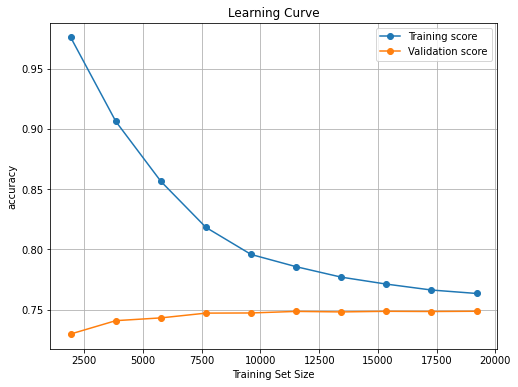

In [36]:
def plot_learning_curve(estimator, X, y, cv=5, scoring='accuracy'):
    train_sizes, train_scores, validation_scores = learning_curve(
        estimator, X, y, cv=cv, scoring=scoring, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10), random_state=42)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)
    
    plt.figure(figsize=(8,6))
    plt.plot(train_sizes, train_scores_mean, label='Training score', marker='o')
    plt.plot(train_sizes, validation_scores_mean, label='Validation score', marker='o')
    plt.xlabel('Training Set Size')
    plt.ylabel(scoring)
    plt.title('Learning Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_learning_curve(model, X_train, y_train)

The plot shows high training score and much lower validation score (big gap) which indicates overfitting — the model memorizes training data but generalizes poorly.

### TODO

Cross-validation - display distributions of performance metrics from cross-validation runs to assess model stability.

Try a Regression Model

Create a presentation with the results.